# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [2]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [3]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.002155 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `../data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [4]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in ['node', 'line', 'source', 'sym_load']:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'../data/{component}.csv')

        # Initialize array
        input_data[component] = initialize_array('input', component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


node     : 2001
line     : 2000
source   :    1
sym_load : 2000
Execution time for Loading Input Data is 0.010170 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/alliander-opensource/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [5]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.004682 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [6]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.000537 s
{'line': 2000, 'node': 2001, 'source': 1, 'sym_load': 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [7]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.002058 s
Min line loading: 0.14188449783808707
Max line loading: 1.6292378285645808


In [8]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Linear Power Flow is 0.000501 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [9]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 1e4 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="H")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,1.002871e+06,1.049051e+06,924711.287497,957200.101965,1.075382e+06,905423.646750,937925.769255,1.069685e+06,1.015249e+06,1.009215e+06,...,1.005255e+06,1.069093e+06,1.042965e+06,935755.179545,906394.135015,9.960279e+05,935439.626888,1.106973e+06,946543.130467,1.090305e+06
2022-01-01 01:00:00,9.981311e+05,1.043204e+06,896707.851946,974486.808653,1.073148e+06,910458.058500,935901.071710,1.068401e+06,1.028494e+06,1.026650e+06,...,1.009434e+06,1.064085e+06,1.036537e+06,915150.269713,924824.703522,9.942952e+05,951804.737260,1.082912e+06,936128.819560,1.077572e+06
2022-01-01 02:00:00,9.833378e+05,1.029733e+06,903100.817344,937014.264873,1.078602e+06,896505.473772,925132.524593,1.064357e+06,1.027282e+06,1.011751e+06,...,1.007744e+06,1.078892e+06,1.058752e+06,910452.536387,893289.562070,1.004583e+06,948349.787736,1.086777e+06,925336.538182,1.094911e+06
2022-01-01 03:00:00,9.841492e+05,1.046645e+06,910789.415670,970910.802629,1.065110e+06,901191.754753,952383.290056,1.072268e+06,1.012551e+06,1.012723e+06,...,9.954191e+05,1.087993e+06,1.041462e+06,901472.832630,925127.823557,1.000111e+06,907982.528788,1.091150e+06,924749.114430,1.083003e+06
2022-01-01 04:00:00,1.007070e+06,1.043126e+06,913720.947978,965360.614876,1.066560e+06,908374.762281,946141.569917,1.044300e+06,1.006786e+06,1.027541e+06,...,9.997145e+05,1.081654e+06,1.041448e+06,910474.407639,909960.340293,1.011428e+06,929552.993616,1.091332e+06,921930.943557,1.085908e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,9.689004e+05,1.043682e+06,911904.035619,955139.474843,1.076987e+06,908248.038655,943946.004154,1.048946e+06,1.008926e+06,1.008524e+06,...,9.980986e+05,1.059041e+06,1.026770e+06,941316.322512,913433.499108,9.957019e+05,937300.718907,1.078965e+06,924943.276582,1.076249e+06
2022-02-11 12:00:00,9.830698e+05,1.038592e+06,895513.874238,980896.304183,1.070465e+06,895416.121476,930908.639607,1.058402e+06,1.029025e+06,1.005008e+06,...,1.009776e+06,1.070563e+06,1.041357e+06,911147.511704,923518.676663,1.001176e+06,954006.937509,1.076831e+06,922985.377595,1.079808e+06
2022-02-11 13:00:00,9.864312e+05,1.050745e+06,918710.660348,957505.009129,1.074499e+06,890667.457356,935162.124830,1.071802e+06,1.005663e+06,1.025159e+06,...,1.006857e+06,1.087378e+06,1.037401e+06,919804.671043,911514.893734,1.001794e+06,930365.957837,1.083419e+06,923268.650258,1.105783e+06
2022-02-11 14:00:00,9.839130e+05,1.036551e+06,913875.040168,969417.542940,1.067075e+06,893108.147959,937844.136616,1.045039e+06,1.020624e+06,1.020546e+06,...,9.996903e+05,1.088587e+06,1.022376e+06,925049.334566,914439.501606,9.981477e+05,937731.897041,1.088536e+06,923470.818159,1.095188e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [10]:
# Initialize an empty load profile
load_profile = initialize_array("update", "sym_load", df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {"sym_load": load_profile}

In [11]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 1.205413 s


In [12]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 0.948894 s


In [13]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.301203 s


## Plotting batch results

Lets say we wish to plot the loading of the `line 7` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

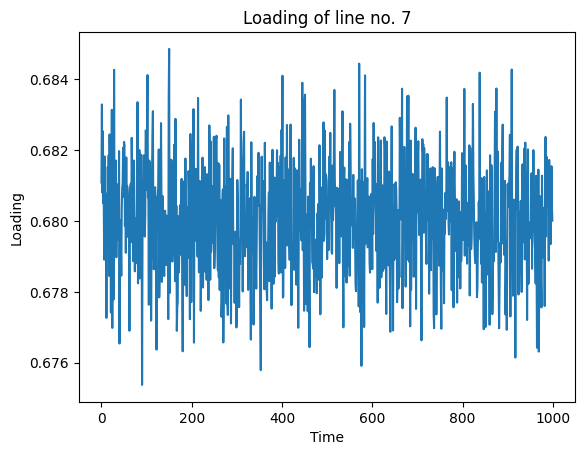

In [14]:
# Plot the loading of line 7 vs time.
result_loading = output_data["line"]["loading"][:,6]
plt.plot(result_loading)
plt.title('Loading of line no. 7')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line 7` is greater than `68.4%`

In [15]:
# Times when loading of line 7 when its greater than 68.4%
ind = np.where(result_loading > 0.684)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-02 04:00:00', '2022-01-05 06:00:00',
               '2022-01-07 06:00:00', '2022-01-17 17:00:00',
               '2022-01-24 19:00:00', '2022-01-25 08:00:00',
               '2022-02-04 22:00:00', '2022-02-07 21:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [16]:
n_lines = len(input_data["line"])

# Initialize an empty line profile
line_profile = initialize_array("update", "line", (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data["line"]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {"line": line_profile}

In [17]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 2.345358 s


In [18]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 2.589651 s


In [19]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 1.201120 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [20]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 2.511464 s
Execution time for Single thread is 2.452706 s
Execution time for Two threads in parallel is 1.303447 s
Execution time for Four threads in parallel is 0.690655 s
Execution time for Use number of threads based the machine hardware is 0.524156 s
